In [136]:
import matplotlib.pyplot as plt
import open3d as o3d
import os
import sys
import h5py
import json
import numpy as np
sys.path.append("../..")
sys.path.append("..")   
from data.utils import distinct_colors
from models.datasets import SorghumDatasetWithNormals, TreePartNetDataset, TreePartNetOriginalDataset, SorghumDatasetTPNFormat
from models.nn_models import *
from data.load_raw_data import load_real_ply_with_labels
from data.utils import distinct_colors
from train_and_inference.test import *
from data.utils import create_ply_pcd_from_points_with_labels

plt.style.use('seaborn')

In [122]:
def draw_results(plt_points, plt_labels, plt_preds):
    fig = plt.figure(figsize=(10,10))
    
    all_labels = list(set(plt_labels))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))

    gt_colors = np.zeros((plt_labels.shape[0],3))
    for i, l in enumerate(all_labels):
        gt_colors[plt_labels == l, :] = d_colors[i]

    all_labels = list(set(plt_preds))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))
        
    pred_colors = np.zeros((plt_preds.shape[0],3))
    for i, l in enumerate(list(set(plt_preds))):
        pred_colors[plt_preds == l, :] = d_colors[i]

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=gt_colors, alpha=1)
    ax1.grid(False)
    ax1.axis("off")
    ax1.set_facecolor("white")
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=pred_colors, alpha=1)
    ax2.grid(False)
    ax2.axis("off")
    ax2.set_facecolor("white")

    plt.tight_layout()
    plt.show()

In [127]:
# experiment_params = load_json("/speedy/ariyanzarei/sorghum_segmentation/experiments/SorghumPartNetSemantic/SPNS/EXP_01_SorghumPartNetSemantic_SPNS.json")
# dataset_name = experiment_params["dataset"]
# dataset_path = experiment_params["test_data"]
# model_name = experiment_params["model_name"]
# experiment_id = experiment_params["experiment_id"]
# if dataset_name == "SPNS":
#     point_key, label_key = "points", "labels"
# elif dataset_name == "TPN":
#     point_key, label_key = "points", "primitive_id"
# model_path = os.path.join(
#         "/speedy/ariyanzarei/sorghum_segmentation/results",
#         "training_logs",
#         model_name,
#         dataset_name,
#         experiment_id,
#         "checkpoints",
#     )
# model = load_model(model_name, model_path)

experiment_params = load_json("/speedy/ariyanzarei/sorghum_segmentation/experiments/SorghumPartNetInstance/SPNS/EXP_08_SorghumPartNetInstance_SPNS.json")
dataset_name = experiment_params["dataset"]
dataset_path = experiment_params["test_data"]
model_name = experiment_params["model_name"]
experiment_id = experiment_params["experiment_id"]
if dataset_name == "SPNS":
    point_key, label_key = "points", "labels"
elif dataset_name == "TPN":
    point_key, label_key = "points", "primitive_id"
model_path = os.path.join(
        "/speedy/ariyanzarei/sorghum_segmentation/results",
        "training_logs",
        model_name,
        dataset_name,
        experiment_id,
        "checkpoints",
    )
model = load_model(model_name, model_path)

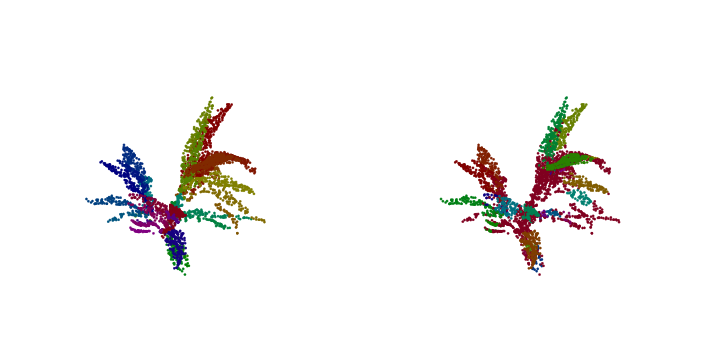

True

In [137]:
ind = 2
points, label = load_data_directory("/space/ariyanzarei/sorghum_segmentation/dataset/SPNR", model_name)

t_points = torch.from_numpy(points[ind]).type(torch.DoubleTensor)

preds = model(t_points.unsqueeze(0))

if model_name == "SorghumPartNetSemantic":
    preds = F.softmax(preds, dim=1)
    preds = preds.squeeze().cpu().detach().numpy().T
    preds = np.argmax(preds, 1)
elif model_name == "SorghumPartNetInstance":
    preds = get_final_clusters_SPN(preds)
elif model_name == "TreePartNet":
    preds = get_final_clusters_TPN(preds)

draw_results(points[ind], label[ind], preds)

gt_ply = create_ply_pcd_from_points_with_labels(points[ind],label[ind])
pred_ply = create_ply_pcd_from_points_with_labels(points[ind],preds)
o3d.io.write_point_cloud("gt.ply", gt_ply)
o3d.io.write_point_cloud("pred.ply", pred_ply)

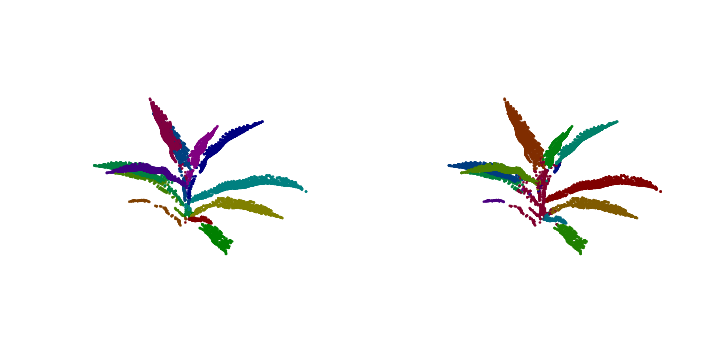

In [134]:
ind = 6
test_data, test_labels = load_data_h5(dataset_path,point_key, label_key)

t_points = torch.from_numpy(test_data[ind]).type(torch.DoubleTensor)

preds = model(t_points.unsqueeze(0))

if model_name == "SorghumPartNetSemantic":
    preds = F.softmax(preds, dim=1)
    preds = preds.squeeze().cpu().detach().numpy().T
    preds = np.argmax(preds, 1)
elif model_name == "SorghumPartNetInstance":
    preds = get_final_clusters_SPN(preds)
elif model_name == "TreePartNet":
    preds = get_final_clusters_TPN(preds)

draw_results(test_data[ind], test_labels[ind].squeeze(), preds)